In [673]:
#@title **Instalação de pymoo**
!pip install pymoo


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# **Inicialização**

In [674]:
#@title **Conecção com o Google Drive**
# Acesso ao Drive

# from google.colab import drive
# drive.mount('/content/drive')

In [675]:
#@title **Bibliotecas**

# Importação do pandas
import pandas as pd

# Importação do numpy
import numpy as np

# Importa MatPlot
import matplotlib.pyplot as plt

from pandas.compat import numpy
import math

import numpy as np

import random
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.ref_dirs import get_reference_directions

In [1]:
#@title **Dados de consumo database Bear_assembly_Angel**

arquivo = "./Data-Base/Genome_Separate_Buildings/Bear_assembly_Angel.csv"

consumo = pd.read_csv(arquivo, delimiter=",").iloc[:,1:]
consumo = consumo.set_axis(list(consumo.iloc[:,0]), axis=0).iloc[:,1:]

# Converter o índice para o tipo de dados 'datetime'
consumo.index = pd.to_datetime(consumo.index)

consumo = consumo.loc["2017-01-01 00:00:00":,:]

# Converter o índice para o formato datetime (caso ainda não esteja)
consumo.index = pd.to_datetime(consumo.index)

# Criar uma série com intervalo de horas para o período desejado
periodo_completo = pd.date_range(start=consumo.index.min(), end=consumo.index.max(), freq='1H')

# Reamostrar o DataFrame para o novo período completo e aplicar a interpolação linear
consumo_interp = consumo.reindex(periodo_completo).interpolate(method='linear')

consumo = consumo_interp
consumo = consumo.iloc[:(len(consumo.iloc[:,0])-3),:]*1000
consumo

NameError: name 'pd' is not defined

In [677]:
#@title **Acesso aos Arquivos de Consumo**

arquivo = "./Faturas/Dados.csv"


df = pd.read_csv(arquivo, delimiter=",", header=None).iloc[:14,:]

df = df.set_axis(list(df.iloc[:,0]), axis=0).iloc[:,1:]
df = df.set_axis(list(df.iloc[1,:]), axis=1)

ponta = df.iloc[2:,2:3].astype('float64')
fora_ponta = df.iloc[2:,7:8].astype('float64')

tou = pd.DataFrame(index=pd.date_range(start='2017-01-01 00:00:00', end='2017-12-31 23:00:00', freq='1H'))
tou['tou'] = 0
for i in range(1,13):
  tou.loc[tou.index.month == i] = fora_ponta.iloc[i-1,0]/len(tou.loc[tou.index.month == i])
  tou.loc[(tou.index.hour >= 18) & (tou.index.hour <= 21) & (tou.index.month == i)] = ponta.iloc[i-1,0]/len(tou.loc[tou.index.month == i])
tou = tou.iloc[:(len(tou.iloc[:,0])-3),:]
tou[:24]

,tou
2017-01-01 00:00:00,0.000398
2017-01-01 01:00:00,0.000398
2017-01-01 02:00:00,0.000398
2017-01-01 03:00:00,0.000398
2017-01-01 04:00:00,0.000398
2017-01-01 05:00:00,0.000398
2017-01-01 06:00:00,0.000398
2017-01-01 07:00:00,0.000398
2017-01-01 08:00:00,0.000398
2017-01-01 09:00:00,0.000398


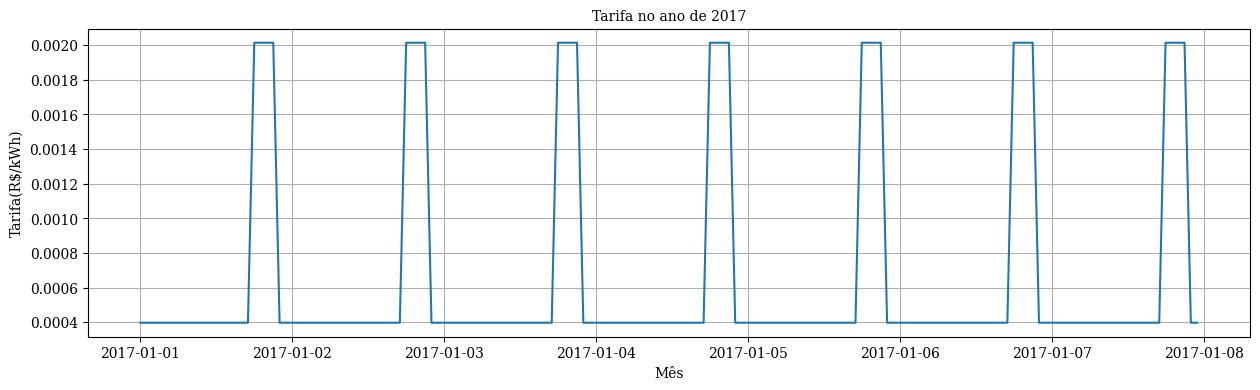

In [678]:
#@title **Tarifa no ano de 2017**
plt.figure(figsize=(15,4))

plt.grid(True)
plt.title('Tarifa no ano de 2017',  fontsize = 10)
plt.ylabel('Tarifa(R$/kWh)',  fontsize = 10)
plt.xlabel('Mês',  fontsize = 10)

plt.plot(tou.iloc[:168,:])

plt.show()

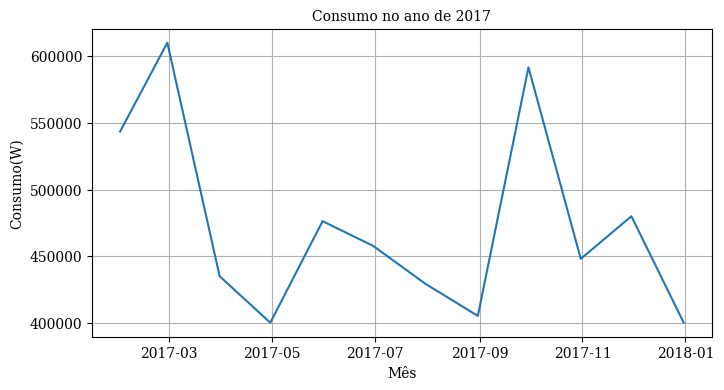

In [679]:
#@title **Comsumo no ano de 2017**
plt.figure(figsize=(8,4))

plt.grid(True)
plt.title('Consumo no ano de 2017',  fontsize = 10)
plt.ylabel('Consumo(W)',  fontsize = 10)
plt.xlabel('Mês',  fontsize = 10)

plt.plot(consumo.resample('M').mean())

plt.show()

In [680]:
#@title **Acesso aos Arquivos Meterologicos**

arquivo = "./dados temporais/2017/INMET_SE_ES_A612_VITORIA_01-01-2017_A_31-12-2017.CSV"

DadosMet = pd.read_csv(arquivo, delimiter=";", header=None, encoding="utf-8", skiprows=9)

colunas_selecionadas = [0,1,6, 7, 18]

DadosMet = DadosMet[colunas_selecionadas]
DadosMet.columns=['Dia','Hora','radiacao', 'temperatura', 'vento']
DadosMet = DadosMet.set_axis(list(DadosMet.iloc[:,0]), axis=0).iloc[:,1:]

DadosMet = DadosMet.replace("-9999", "0")

# # Trocar vírgulas por pontos na coluna
DadosMet.iloc[:,1] = DadosMet.iloc[:,1].str.replace(",", ".")
DadosMet.iloc[:,2] = DadosMet.iloc[:,2].str.replace(",", ".")
DadosMet.iloc[:,3] = DadosMet.iloc[:,3].str.replace(",", ".")


DadosMet.iloc[:,1:4] = DadosMet.iloc[:,1:4].astype("float64")

# Acerto zona
zona = pd.DataFrame({'Hora': ['21:00', '22:00', '23:00']}, index=["2016-12-31","2016-12-31","2016-12-31"])
zona = pd.concat([zona, DadosMet.iloc[:len(DadosMet)-3,0:1]])

DadosMet.index = zona.index
DadosMet.iloc[:,0] = zona

# Converter o índice para o tipo de dados 'datetime'
DadosMet.index = pd.to_datetime(DadosMet.index)

DadosMet = DadosMet.iloc[3:,:]

# Combine as colunas 'Dia' e 'Hora' em uma única coluna de data e hora
DadosMet['DateTime'] = pd.to_datetime(DadosMet.index.astype(str) + ' ' + DadosMet['Hora'])

# Configure o índice com a coluna 'DateTime'
DadosMet.set_index('DateTime', inplace=True)

# Remova as colunas 'Dia' e 'Hora', pois agora estão no índice
DadosMet.drop(columns=['Hora'], inplace=True)

# Redefina o nome do índice para None
DadosMet.index.name = None

DadosMet.index = pd.to_datetime(DadosMet.index)

DadosMet.iloc[:,0] = DadosMet.iloc[:,0]/1000
DadosMet

,radiacao,temperatura,vento
2017-01-01 00:00:00,0.0,25.9,1.9
2017-01-01 01:00:00,0.0,25.8,2.2
2017-01-01 02:00:00,0.0,25.5,1.4
2017-01-01 03:00:00,0.0,24.6,1.1
2017-01-01 04:00:00,0.0,24.3,0.9
...,...,...,...
2017-12-31 16:00:00,1.8275,30.5,3.9
2017-12-31 17:00:00,0.8012,28.4,3.8
2017-12-31 18:00:00,0.261,27.6,3.4
2017-12-31 19:00:00,0.009,27.4,2.6


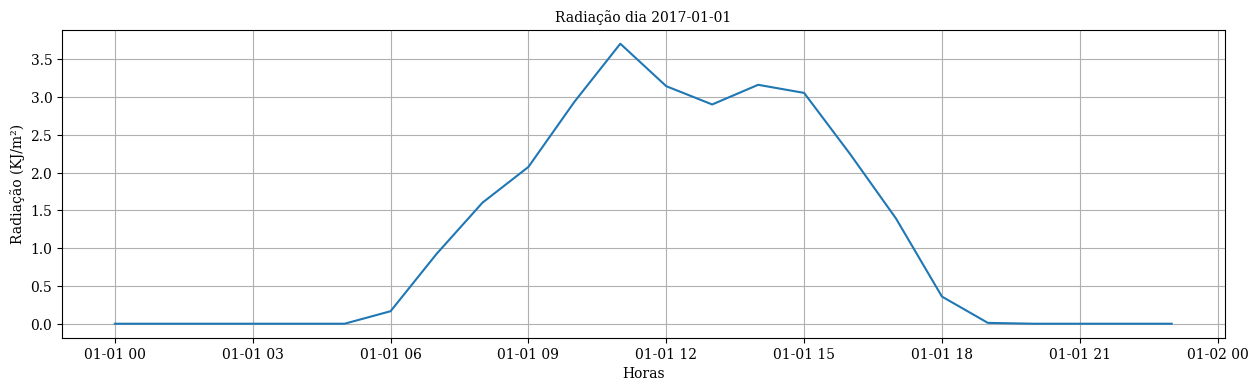

In [681]:
#@title **Gráfico radiação 2017-01-01**
plt.figure(figsize=(15,4))

plt.grid(True)
plt.title('Radiação dia 2017-01-01',  fontsize = 10)
plt.ylabel('Radiação (KJ/m²)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet.iloc[:24,0])
plt.show()

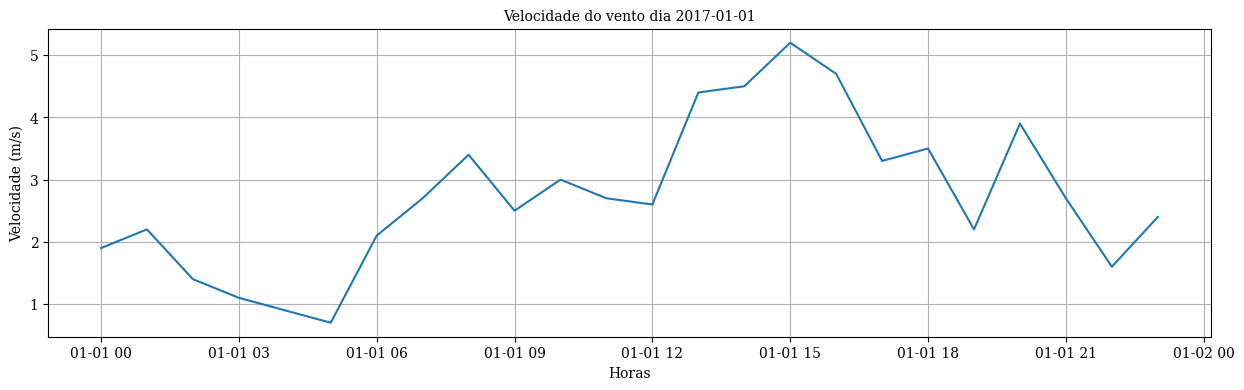

In [682]:
#@title **Gráfico Vento 2017-01-01**
plt.figure(figsize=(15,4))

plt.grid(True)
plt.title('Velocidade do vento dia 2017-01-01',  fontsize = 10)
plt.ylabel('Velocidade (m/s)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet.iloc[:24,2])
plt.show()

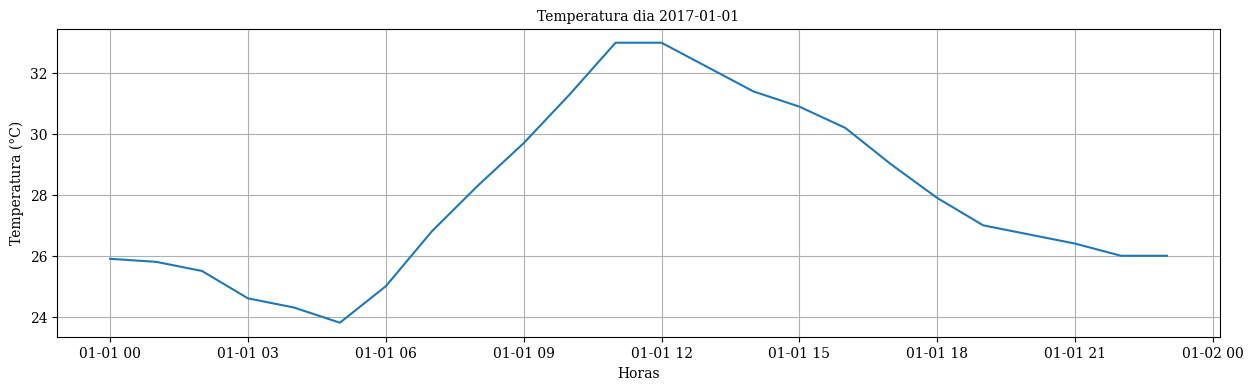

In [683]:
plt.figure(figsize=(15,4))

plt.grid(True)
plt.title('Temperatura dia 2017-01-01',  fontsize = 10)
plt.ylabel('Temperatura (°C)',  fontsize = 10)
plt.xlabel('Horas',  fontsize = 10)

plt.plot(DadosMet.iloc[:24,1])
plt.show()

In [684]:
#@title **Informações da placa**
#POTENCIA GERADA PELOS PV's DO MODELO 1 Yingli 250W Policristalino
Imppt=17.46             # é a corrente no ponto de máxima potência (A).
Vmppt=33.94             # é a tensão no ponto de máxima potência (V);
Not=45                  # é a temperatura nominal de operação da célula (oC);
Isc=15.74               # é a corrente de curto circuito da célula (A);
Voc=42.34               # é a tensão de circuito aberto do módulo (V);
Ki=0.046                # é o coeficiente de corrente/temperatura (A/ oC);
Kv=-0.266               # é o coeficiente de tensão/temperatura (V/ oC);
RNOCT = 800
ta = 0.9
nc = 0.216

tam = len(DadosMet)     # é a quantidade de horas
power_placa = Voc*Isc   # é a potencia da Placa
horas_exposto = 12      # é a quantidade de horas de exposição da placa

In [703]:
#@title **Quantidade de Paineis**

power_generete = power_placa * horas_exposto # Wh

consumo_medio = consumo.mean() * 24  # Wh/dia

NPaineis =  math.ceil(consumo_medio / power_generete)
NPaineis

1417

In [686]:
#@title **Aerogerador**

# #Inicializacao dos Parametros do Aerogerador VERNE 555
# VelCuttin = 2.2;
# VelCutout = 16;

# v=[2.2,6,7.1,8.2,9,9.7,10.5,10.8,13.8,16];
# p=[0,1,2,3,4,5,6,6.5,7,6.7];

# coeficientes = polyfit(v,p,5);

# tam=size(DadosMet,1);

# %Calculo de potencia do aerogerador por hora
# PotAero  = zeros(tam,1);
# for i=1:tam
#     if(DadosMet(i,6)>= VelCuttin && DadosMet(i,6) <= VelCutout)
#         PotAero(i) =    coeficientes(1)*DadosMet(i,6)^5+ ...
#                         coeficientes(2)*DadosMet(i,6)^4+ ...
#                         coeficientes(3)*DadosMet(i,6)^3+ ...
#                         coeficientes(4)*DadosMet(i,6)^2+ ...
#                         coeficientes(5)*DadosMet(i,6)^1+ ...
#                         coeficientes(6);
#      elseif (DadosMet(i,6) > VelCutout)
#         PotAero(i)=6.7;
#      else
#         PotAero(i)=0;
#     end

#     if(PotAero(i)<0)
#        PotAero(i)=0;
#     end

# end
# PotAGM(:,1)= PotAero*1000; %unidade Watt

In [687]:
#@title **Painel solar**
PotPVM  = [];
for i in range(tam):
    r   = DadosMet.iloc[i,0]
    Ta  = DadosMet.iloc[i,1]
    Vw  = DadosMet.iloc[i,2]
    Tc  = Ta + ((r/RNOCT) * (9.5/(5.7+3.8*Vw)) * (Not-20) * (1 - (nc/ta)))   # Ta + r*(Not-20)/0.8
    I   = r * (Isc + Ki *(Tc-25))
    V   = Voc - Kv *(Tc-25)
    FF  = (Vmppt * Imppt)/(Voc * Isc)
    PotPVM.append(NPaineis * FF * V * I)

PotPVM = pd.DataFrame(PotPVM, index=DadosMet.index, columns=["Power (kW)"])

PotPVM.iloc[:24,:]

,Power (kW)
2017-01-01 00:00:00,0.000000e+00
2017-01-01 01:00:00,0.000000e+00
2017-01-01 02:00:00,0.000000e+00
2017-01-01 03:00:00,0.000000e+00
2017-01-01 04:00:00,0.000000e+00
2017-01-01 05:00:00,0.000000e+00
2017-01-01 06:00:00,1.390584e+05
2017-01-01 07:00:00,7.886255e+05
2017-01-01 08:00:00,1.387186e+06
2017-01-01 09:00:00,1.819941e+06


In [704]:
sum(PotPVM.iloc[:,0]-consumo.iloc[:,0])

1340739159.6239557

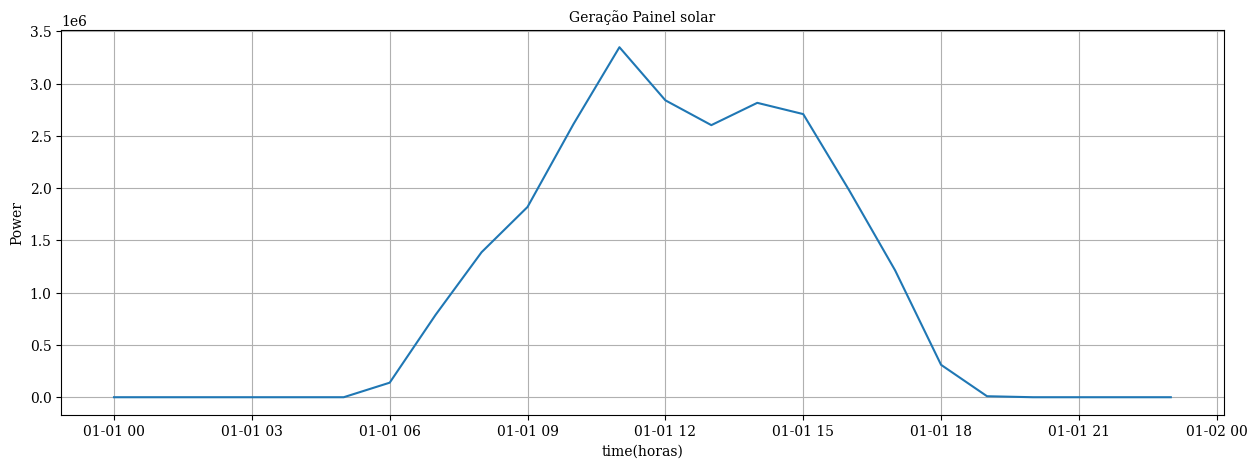

In [688]:
#@title **Geração no dia 1 de janeiro 2017**
plt.figure(figsize=(15,5))

plt.grid(True)
plt.title('Geração Painel solar',  fontsize = 10)
plt.ylabel('Power',  fontsize = 10)
plt.xlabel('time(horas)',  fontsize = 10)

plt.plot(PotPVM.iloc[:24,:])
plt.show()

In [689]:
#@title **EnergBaterry**

def energBaterry(g, l, max_battery):
  battery = 0
  bat   = l.copy()*0
  load  = l.copy()
  grid  = g.copy()
  for i, energ in enumerate(zip(load.iloc[:,0], grid.iloc[:,0])):
    c, geracao = energ
    if(i):
      battery    = bat.iloc[i-1,0]

    res   = geracao - c

    if(res < 0):
      c = (-1) * res
      res = 0
      c = c - battery
      if(c < 0):
        battery = (-1) * c
        c = 0
      else:
        battery = 0
    elif (battery < max_battery):
      c = 0
      if (res <= (max_battery-battery)):
        battery = battery + res
        res = 0
      else:
        battery = max_battery
        res     = res - (max_battery - battery)
    else:
      c = 0

    load.iloc[i,0]  = c
    grid.iloc[i,0]  = res
    bat.iloc[i,0]   = battery
  return grid, load, bat

max_battery = 0 #2kW
grid, load, baterry =energBaterry(PotPVM, consumo, max_battery)
load.sum()

meter_reading    2.133664e+09
dtype: float64

In [690]:
#@title **Custo anual de eletricidade**
c_fit = 0
c_tou = tou.iloc[:,0]
Ce = lambda x: sum(((energBaterry(PotPVM, consumo, x)[1]).iloc[:,0])*c_tou)
round(Ce(572241),2)

1756070.55

In [691]:
#@title **Custo anual relacionado à bateria**
SOH         = 0.8
rep         = 0.6
c_ic        = 0.684372
e_b         = 2000 # 3.9 * 10**6 # capacidade da bateria # Otimizar

c_bat       = lambda x: (((1-SOH)/(1-rep))*c_ic*x)

round(c_bat(3900000),2)

1334525.4

In [692]:
#@title **Custo anual total do sistema solar com bateria**
Cop = lambda x: c_bat(x) + Ce(x)
round(Cop(2000),2)

2026596.62

In [693]:
#@title **C_sav**
C_pv = (consumo.iloc[:,0] - PotPVM.iloc[:,0]) * c_tou
C_pv [C_pv < 0] = 0
C_pv = C_pv.sum()

C_sav = lambda x: C_pv - Cop(x)
round(C_sav(2000), 2)

-48.64

In [694]:
#@title **Retorno de investimento**

roi = lambda x: (C_sav(x)/c_bat(x))*100
round(roi(348528.36539327),2)

15.13

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     62 |             - |             -
     2 |      200 |     77 |  0.0062900462 |         ideal
     3 |      300 |     87 |  0.0038516874 |         ideal
     4 |      400 |     90 |  0.0010902717 |             f
     5 |      500 |     96 |  0.0024718206 |             f
     6 |      600 |     98 |  0.0031785721 |             f
     7 |      700 |     99 |  0.0005553889 |             f
     8 |      800 |    100 |  0.0027021660 |         nadir
     9 |      900 |    100 |  0.0002105419 |             f
    10 |     1000 |     98 |  0.0053821114 |         ideal
Individual:  [2286687.64119992]
Objectives:  [782472.49719164 767398.11572178]
Distancia:   [1095975.8559724984]
------------------------
Individual:  [1665589.1309483]
Objectives:  [ 569941.28236268 1047759.47915719]
Distancia:   [1192741.7958237869]
------------------------
Individual:  [2354892.32964017]
Objectives:  [805811.18671025 745998.43766

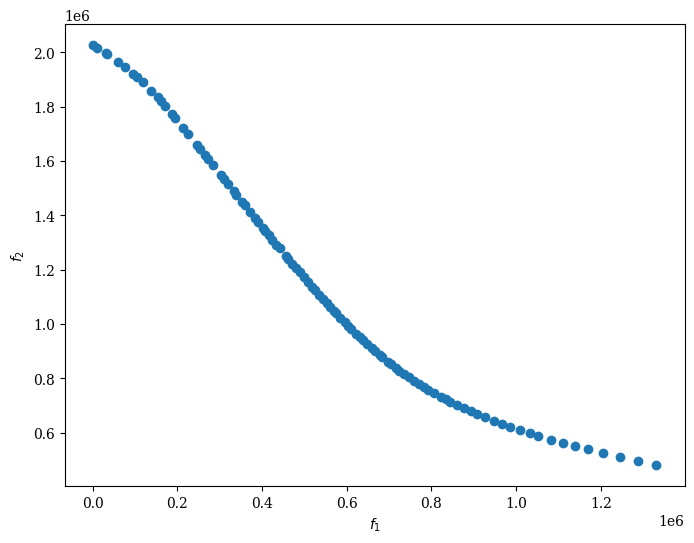

In [718]:
# Função para realizar a otimização com base em uma seed específica
def run_optimization(problem, algorithm, seed, verbose=False):
    # Executar a otimização com a seed específica
    result = minimize(problem, algorithm, seed=seed, termination=('n_gen', 1), verbose=verbose)

    # Armazenar o resultado e a seed diretamente na lista
    results_list.append((result, seed))

# Definir o problema de otimização
n_var = 1
max_baterry = 3.9*10**6
objs = [c_bat, lambda x: [sum(energBaterry(PotPVM, consumo,x)[1].iloc[:,0] * c_tou)]]
problem = FunctionalProblem(n_var, objs, xl=np.full(n_var, 0), xu=np.full(n_var, max_baterry))

# Configurar o algoritmo NSGA-III
num_ref_dirs = 100
ref_dirs_custom = np.linspace(0, max_baterry, num_ref_dirs)
ref_dirs_custom = np.column_stack((ref_dirs_custom, np.flip(ref_dirs_custom)))
algorithm = NSGA3(pop_size=100, ref_dirs=ref_dirs_custom)
    
# Lista de seeds que serão utilizadas para a otimização
num_seeds = 5
seeds = np.random.randint(1, 1000, size=num_seeds).tolist()

# Criar uma lista para armazenar os resultados e as seeds
results_list = []

# # Criar threads para executar a otimização para cada seed
# threads = [threading.Thread(target=run_optimization, args=(problem, algorithm, seed,)) for seed in seeds[:len(seeds)-1]]
# threads.append(threading.Thread(target=run_optimization, args=(problem, algorithm, seeds[len(seeds)-1], True,)))

result = minimize(problem, algorithm, seed=980, termination=('n_gen', 10), verbose=True)

# # Iniciar as threads
# for thread in threads:
#     thread.start()

# # Aguardar todas as threads serem concluídas
# for thread in threads:
#     thread.join()
    
# result_max = results_list[0]
# for result in results_list:
#     len_population = len(result[0].X)
#     if (len(result_max[0].X)<=len_population):
#         result = result

# # Acessar os resultados
# result = result_max[0]

final_population = result.X
final_objectives = result.F

# Imprimir os resultados
lista = []
for individual, objectives in zip(final_population, final_objectives):
    dist = np.linalg.norm([0, 0] - objectives)
    print("Individual: ", individual)
    print("Objectives: ", objectives)
    print("Distancia:  ", [dist])
    print("------------------------")

    lista.append((individual, objectives, dist))

print(min(lista, key=lambda x: x[2]))

scatter_plot = Scatter().add(result.F).show()

scatter_plot.save("scatter_plot.png")

In [696]:
for result in results_list:
    print(len(result[0].X), result) 

In [697]:
# 49 [298]
# 52 (<pymoo.core.result.Result object at 0x000001D55FC04AD0>, 980)
print(len(result.X))

62


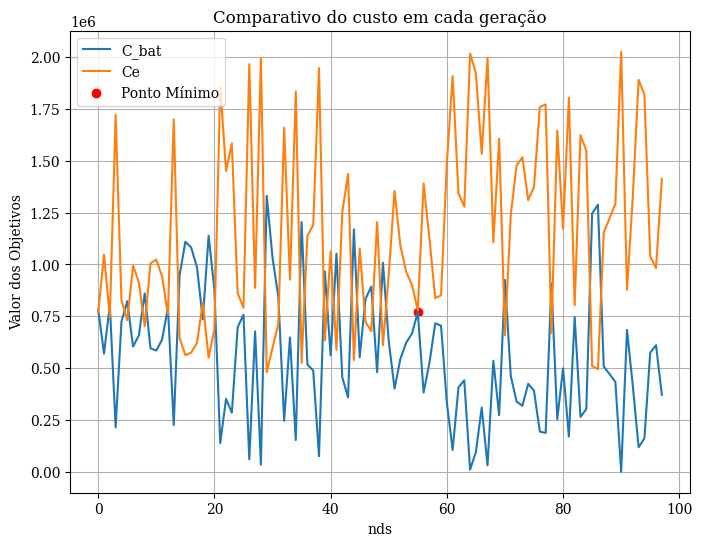

In [719]:
# Criação do gráfico
plt.figure(figsize=(8, 6))

# Transposta do array final_objectives para facilitar o plotting
final_objectives_transpose = final_objectives.T

# Plotar cada objetivo em uma reta usando broadcasting do NumPy
plt.plot(final_objectives_transpose[0], label="C_bat")
plt.plot(final_objectives_transpose[1], label="Ce")

# Encontrar o ponto mínimo na lista de tuplas (individual, objectives, dist)
min_dist_point = min(lista, key=lambda x: x[2])

# Extrair o índice do ponto mínimo na lista
min_dist_index = lista.index(min_dist_point)

# Marcando o ponto mínimo no gráfico
plt.scatter(min_dist_index, min_dist_point[1][0], color='red', label='Ponto Mínimo')

plt.xlabel("nds")
plt.ylabel("Valor dos Objetivos")
plt.legend()
plt.grid(True)
plt.title("Comparativo do custo em cada geração")
plt.show()

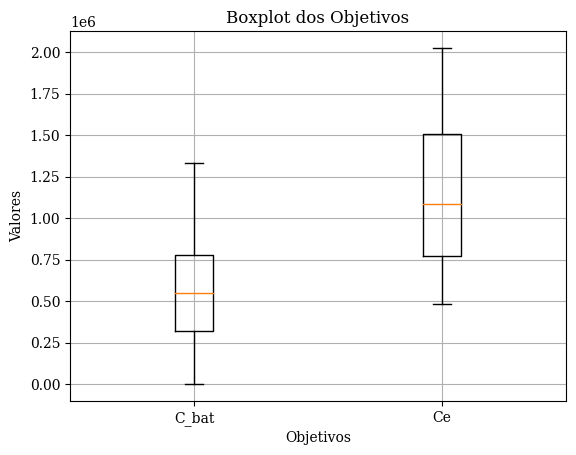

In [720]:
import matplotlib.pyplot as plt

# Rótulos dos objetivos
labels = ['C_bat', 'Ce']

# Criar o boxplot
plt.boxplot(final_objectives, labels=labels)

# Configurar o gráfico
plt.title('Boxplot dos Objetivos')
plt.xlabel('Objetivos')
plt.ylabel('Valores')
plt.grid(True)

# Exibir o gráfico
plt.show()

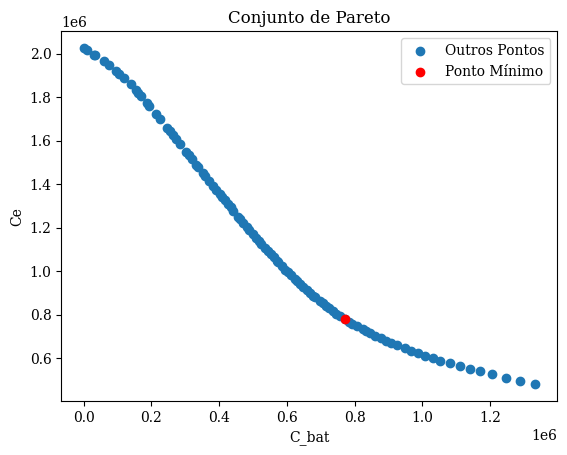

In [721]:
# Função para verificar se um ponto é dominado por outro ponto
def is_dominated(point, other_points):
    return np.any(np.all(point >= other_points, axis=1))

# Encontrar o conjunto de Pareto
pareto_front = []
for i, point in enumerate(final_objectives):
    if not is_dominated(point, np.delete(final_objectives, i, axis=0)):
        pareto_front.append(point)

pareto_front = np.array(pareto_front)

# Encontrar o ponto mínimo na lista de tuplas (individual, objectives, dist)
min_dist_point = min(lista, key=lambda x: x[2])

# Extrair o índice do ponto mínimo na lista
min_dist_index = lista.index(min_dist_point)

# Plotar o gráfico de dispersão
plt.scatter(final_objectives[:, 0], final_objectives[:, 1], label="Outros Pontos")
plt.scatter(final_objectives[min_dist_index, 0], final_objectives[min_dist_index, 1], color='red', label="Ponto Mínimo")

# Definir os rótulos dos eixos
plt.xlabel("C_bat")
plt.ylabel("Ce")

# Definir o título do gráfico
plt.title("Conjunto de Pareto")

# Exibir a legenda
plt.legend()

# Exibir o gráfico
plt.show()

In [722]:
b = min(lista, key=lambda x: x[2])[0][0]
b

2250199.1207488393

In [723]:
roi(min(lista, key=lambda x: x[2])[0][0])

62.00304805002303

In [724]:
C_pv

2026547.9775350858

In [725]:
Cop(b)

1549132.793431051